In [1]:
import seaborn as sns
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from timeit import default_timer as timer

In [4]:
import pickle
def save_data(data, filepath):
    """Save data to disk using pickle."""

    with open(filepath, 'wb') as handle:
        pickle.dump(data, handle)



def load_data(filepath):
    """Load and return the given pickle file."""

    with open(filepath, 'rb') as handle:
        return pickle.load(handle) 

In [2]:
data_df = pd.read_csv("../../../../ncs/PaperMaterials/Data/257k_final_relevants_with_all_fields.csv", index_col=0)

/var/folders/2b/j70y4jj16273ghx5d_sknkwm0000gn/T/ipykernel_1953/268045509.py:1: DtypeWarning: Columns (1,34,86,111,116,117,120) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv("../../../../ncs/PaperMaterials/Data/257k_final_relevants_with_all_fields.csv", index_col=0)


## # of authors

In [3]:
author_data = data_df[["articletitle", "authors", "authorfullnames"]]

interesting paper: https://onlinelibrary.wiley.com/doi/10.1111/jvs.12710

paper with 506 author: https://www.researchgate.net/publication/332601002_NEOTROPICAL_XENARTHRANS_a_data_set_of_occurrence_of_xenarthran_species_in_the_Neotropics

In [4]:
authors_dict = dict()
for i, uid in enumerate(author_data.index.values):
    if i % 100000 == 0: print(i)
    current_auth_full_name = author_data.loc[uid, "authorfullnames"]
    
    auths_len = 0
    if current_auth_full_name == "Empty":
        # split with ,
        auths_len = len(author_data.loc[uid, "authors"].split(","))    
    else:
        auths_len = len(author_data.loc[uid, "authors"].split(";"))
        
    if auths_len in authors_dict:
        authors_dict[auths_len] += 1
    else:
        authors_dict[auths_len] = 1

0
100000
200000


In [5]:
after_first_n = 5
authors_other_num = 0

sorted_authors = sorted(authors_dict.items(), key=lambda x:x[1], reverse=True)

for a in sorted_authors[after_first_n:]:
    authors_other_num += a[1]

In [6]:
final_num_of_authors = [(str(x[0]), x[1]) for x in sorted_authors[0:after_first_n]] + [("Other", authors_other_num)]
author_distribution = dict()
for fa in final_num_of_authors:
    author_distribution[fa[0]] = fa[1]
myKeys = list(author_distribution.keys())
myKeys.sort()
author_distribution = {i: author_distribution[i] for i in myKeys}
author_distribution

{'1': 24645, '2': 44755, '3': 50713, '4': 44165, '5': 32814, 'Other': 60174}

## Year published distribution

In [7]:
publication_year_data = data_df["publicationyear"]

In [8]:
pub_year_u, pub_year_v = np.unique(publication_year_data, return_counts=True)

In [9]:
year_windows = [1990, 1995, 2000, 2005, 2010, 2015, 2023]

In [10]:
pub_year_nums = []
pub_year_nums_dict = {}
len_of_y_w = len(year_windows)
for i in range(len_of_y_w):
    if i == 0:
        mask = pub_year_u < year_windows[i]
        num = np.sum(pub_year_v[mask])
        pub_year_nums.append(num)
        pub_year_nums_dict["<" + str(year_windows[i])] = num
    else:
        mask = (year_windows[i-1] <= pub_year_u) & (pub_year_u < year_windows[i])
        num = np.sum(pub_year_v[mask])
        pub_year_nums.append(num)
        pub_year_nums_dict[str(year_windows[i-1]) + " - " + str(year_windows[i]-1)] = num

In [11]:
publicationyear_distribution = dict()
for k,v in pub_year_nums_dict.items():
    if k != '<1990':
        publicationyear_distribution[k] = v
publicationyear_distribution

{'1990 - 1994': 9254,
 '1995 - 1999': 15559,
 '2000 - 2004': 22055,
 '2005 - 2009': 33116,
 '2010 - 2014': 48549,
 '2015 - 2022': 128733}

## Disciplines represented --> WoS categories 

In [12]:
woscats = dict()
for i, uid in enumerate(data_df.index.values):
    if i % 100000 == 0: print(i)
    current_woscats = data_df.loc[uid, "woscategories"].split("; ")
    for cw in current_woscats:
        if cw in woscats:
            woscats[cw] += 1
        else:
            woscats[cw] = 1

0
100000
200000


In [13]:
sorted_woscats = sorted(woscats.items(), key=lambda x:x[1], reverse=True)
print(sorted_woscats[0:6])

[('Empty', 72138), ('Environmental Sciences', 40923), ('Ecology', 34111), ('Agronomy', 23472), ('Plant Sciences', 21455), ('Forestry', 17372)]


In [14]:
after_first_n = 6
woscats_other_num = 0

for a in sorted_woscats[after_first_n:]:
    woscats_other_num += a[1]

In [15]:
woscats_other_num

183505

In [16]:
disciplines_distribution = dict()
for sw in sorted_woscats[0:6]:
    if sw[0] == 'Empty':
        disciplines_distribution['Missing'] = sw[1]
    else:
        disciplines_distribution[sw[0]] = sw[1]
disciplines_distribution['Other'] = woscats_other_num
disciplines_distribution

{'Missing': 72138,
 'Environmental Sciences': 40923,
 'Ecology': 34111,
 'Agronomy': 23472,
 'Plant Sciences': 21455,
 'Forestry': 17372,
 'Other': 183505}

### NCS Pathways [Three Bars: Protect, Manage, Restore]

In [17]:
pathway_mapping = { 
                    '1':'Avoided forest conversion',
                    '2':'Forest Reforestation & Rehabilitation',
                    '3':'Natural forest management',
                    '4':'Improved plantations',
                    '5':'Fire management',
                    '6':'Avoided/sustainable woodfuel harvest',
                    '7':'Avoided grassland, savannas, shrublands conversion',
                    '8':'Biochar',
                    '9':'Cropland nutrient management',
                    '10':'Conservation agriculture',
                    '11':'Trees in croplands and agroforestry',
                    '12':'Grazing – optimal intensity',
                    '13':'Grazing – legumes in pastures',
                    '14':'Grazing – improved feed',
                    '15':'Grazing – animal management',
                    '16':'Improved rice cultivation',
                    '17':'Avoided coastal wetland impacts & conversion',
                    '18':'Avoided freshwater wetlands impacts',
                    '19':'Coastal wetlands restoration & rehabilitation',
                    '20':'Freshwater wetlands restoration',
                    '21':'Grassland restoration and rehabilitation',
                    '22':'Afforestation'
                  }
pathway_numbers = [1,7,17,18,3,4,5,6,8,9,10,11,12,13,14,15,16,2,19,20,21,22]
protect_distribution = dict()
manage_distribution = dict()
restore_distribution = dict()

for i, uid in enumerate(data_df.index.values):
    predicted_pathways = data_df.loc[uid, 'predicted_pathway_numbers']
    for pp in predicted_pathways[2:-2].split('\', \''):
        if pp == '34': continue
        if int(pp) in pathway_numbers[:4]:
            if pathway_mapping[pp] in protect_distribution:
                protect_distribution[pathway_mapping[pp]] += 1
            else:
                protect_distribution[pathway_mapping[pp]] = 1
        elif int(pp) in pathway_numbers[4:-5]:
            if pathway_mapping[pp] in manage_distribution:
                manage_distribution[pathway_mapping[pp]] += 1
            else:
                manage_distribution[pathway_mapping[pp]] = 1
        else:
            if pathway_mapping[pp] in restore_distribution:
                restore_distribution[pathway_mapping[pp]] += 1
            else:
                restore_distribution[pathway_mapping[pp]] = 1
print('PROTECT')
print(protect_distribution)
print('MANAGE')
print(manage_distribution)
print('RESTORE')
print(restore_distribution)

PROTECT
{'Avoided forest conversion': 36996, 'Avoided freshwater wetlands impacts': 13229, 'Avoided coastal wetland impacts & conversion': 21307, 'Avoided grassland, savannas, shrublands conversion': 18550}
MANAGE
{'Natural forest management': 74643, 'Conservation agriculture': 96749, 'Improved plantations': 24548, 'Improved rice cultivation': 10414, 'Cropland nutrient management': 46046, 'Biochar': 21177, 'Trees in croplands and agroforestry': 12396, 'Fire management': 19517, 'Grazing – animal management': 22111, 'Grazing – improved feed': 10469, 'Avoided/sustainable woodfuel harvest': 4830, 'Grazing – legumes in pastures': 4580, 'Grazing – optimal intensity': 8274}
RESTORE
{'Grassland restoration and rehabilitation': 20635, 'Forest Reforestation & Rehabilitation': 29125, 'Afforestation': 10011, 'Coastal wetlands restoration & rehabilitation': 25186, 'Freshwater wetlands restoration': 14412}


### Cobenefits [One Bar with the groups Biodiversity, Environment, Material HWB Benefits, Non-Material HWB Benefits

In [18]:
cobenefit_letters = ['B','C','D','A','E','F','G','H','I','K','J']
cobenefit_distribution = dict()
cobenefit_distribution['Biodiversity'] = 0
cobenefit_distribution['Environment'] = 0
cobenefit_distribution['Material HWB Benefits'] = 0
cobenefit_distribution['Non-Material HWB Benefits'] = 0
cobenefit_distribution['Health'] = 0

for i, uid in enumerate(data_df.index.values):
    predicted_cobenefits = data_df.loc[uid, 'predicted_benefits']
    for pc in predicted_cobenefits[2:-2].split('\', \''):
        if pc in cobenefit_letters[:2]:
            cobenefit_distribution['Material HWB Benefits'] += 1
        elif pc in cobenefit_letters[3]:
            cobenefit_distribution['Health'] += 1
        elif pc in cobenefit_letters[3:-2]:
            cobenefit_distribution['Non-Material HWB Benefits'] += 1
        elif pc in cobenefit_letters[-2]:
            cobenefit_distribution['Biodiversity'] += 1
        else:
            cobenefit_distribution['Environment'] += 1
cobenefit_distribution

{'Biodiversity': 131357,
 'Environment': 242775,
 'Material HWB Benefits': 271046,
 'Non-Material HWB Benefits': 87003,
 'Health': 17381}

### Single vs multiple pathways [one bar, binary]

In [19]:
pathway_occurence_distribution = dict()
pathway_occurence_distribution['single'] = 0
pathway_occurence_distribution['multiple'] = 0
for i, uid in enumerate(data_df.index.values):
    predicted_pathways = data_df.loc[uid, 'predicted_pathway_numbers'][2:-2].split('\', \'')
    if len(predicted_pathways) == 1:
        pathway_occurence_distribution['single'] += 1
    else:
        pathway_occurence_distribution['multiple'] += 1
pathway_occurence_distribution

{'single': 77390, 'multiple': 179876}

### Single vs multiple co-benefits [one bar, binary]

In [20]:
cobenefit_occurence_distribution = dict()
cobenefit_occurence_distribution['single'] = 0
cobenefit_occurence_distribution['multiple'] = 0
for i, uid in enumerate(data_df.index.values):
    predicted_cobenefits = data_df.loc[uid, 'predicted_benefits'][2:-2].split('\', \'')
    if len(predicted_cobenefits) == 1:
        cobenefit_occurence_distribution['single'] += 1
    else:
        cobenefit_occurence_distribution['multiple'] += 1
cobenefit_occurence_distribution

{'single': 15958, 'multiple': 241308}

### % of papers with location data by continent -->  Geolocation (Continents/no geography)

In [22]:
from countriesmaster import countries
import pycountry_convert as pc

In [23]:
cc = countries.CountryChecker('countriesmaster/TM_WORLD_BORDERS-0.3/TM_WORLD_BORDERS-0.3.shp')

In [26]:
not_found_country = 0
not_found_country_list = list()
found_continents = dict()
start_time = timer()

for i, uid in enumerate(data_df[data_df['geolocation_status'] == 'found'].index.values):
    
    if (i%10000==0) and (i!=0): 
        print(i, timer()-start_time)
    
    location_data = data_df.loc[uid, 'location']
    current_continents = list()
    for ld in location_data[2:-2].split('\', \''):
        lat, lon = [float(ld_) for ld_ in ld.split(',')]
        country = cc.getCountry(countries.Point(lat, lon))
        try:
            country_code = pc.country_name_to_country_alpha2(country.__str__(), cn_name_format="default")
            continent_name = pc.country_alpha2_to_continent_code(country_code)
            current_continents.append(pc.convert_continent_code_to_continent_name(continent_name))
            #continent = continents_and_countries[country.__str__()]
            #current_continents.append(continent)
        except:
            if country is None:
                not_found_country += 1
            else:
                not_found_country += 1
                not_found_country_list.append(country)
    for ccc in list(set(current_continents)):
        if ccc in found_continents:
            found_continents[ccc] += 1
        else:
            found_continents[ccc] = 1

10000 176.117401959
20000 352.131755334
30000 524.9742627920001
40000 696.6966490420001
50000 890.254916417
60000 1072.7185525
70000 1250.987036334
80000 1430.617955
90000 1605.6080975
100000 1781.615341417
110000 1952.838753792
120000 2124.15584675
130000 2300.812772667
140000 2472.4016308339997


In [27]:
not_found_country

10705

In [28]:
for i,nfc in enumerate(not_found_country_list):
    not_found_country_list[i] = nfc.__str__()

In [29]:
print(len(not_found_country_list))
print(len(list(set(not_found_country_list))))
for nfcl in set(not_found_country_list):
    print(nfcl.__str__())

4324
18
Wallis and Futuna Islands
Reunion
United States Minor Outlying Islands
Western Sahara
Timor-Leste
Burma
Holy See (Vatican City)
Cote d'Ivoire
Antarctica
The former Yugoslav Republic of Macedonia
French Southern and Antarctic Lands
Libyan Arab Jamahiriya
Iran (Islamic Republic of)
South Georgia South Sandwich Islands
Netherlands Antilles
Pitcairn Islands
Saint Helena
Saint Barthelemy


In [30]:
continent_distribution = dict()
for k,v in found_continents.items():
    if k == 'Antarctica':
        continue
    else:
        continent_distribution[k] = v
continent_distribution['Missing'] = data_df[data_df['geolocation_status'] == 'notfound'].shape[0]
continent_distribution

{'North America': 53221,
 'Oceania': 9766,
 'Asia': 42989,
 'Europe': 34679,
 'Africa': 15304,
 'South America': 13551,
 'Missing': 109570}

### % of papers with biodiversity data

In [24]:
biodiv_distribution = dict()
biodiv_distribution['Yes'] = data_df[data_df['biodiv_species_name'] != 'Not Found'].shape[0]
biodiv_distribution['No'] = data_df[data_df['biodiv_species_name'] == 'Not Found'].shape[0]
biodiv_distribution

{'Yes': 107313, 'No': 149953}

In [25]:
kingdom_distribution = dict()
start_time = timer()

for i, uid in enumerate(data_df[data_df['biodiv_species_name'] != 'Not Found'].index.values):
    
    if (i%100000==0) and (i!=0): 
        print(i, timer()-start_time)
    
    all_kingdoms = data_df.loc[uid, 'biodiv_kingdom_name'][2:-2].split('\', \'')
    unique_kingdoms_list = list()
    all_species = data_df.loc[uid, 'biodiv_species_name'][2:-2].split('\', \'')
    seen_species = list()
    unique_species_indices = list()
    for j,s in enumerate(all_species):
        if s in seen_species: 
            continue
        else:
            seen_species.append(s)
            unique_species_indices.append(j)
    for k in unique_species_indices:
        unique_kingdoms_list.append(all_kingdoms[k])    
        
    for k in unique_kingdoms_list:
        if k in kingdom_distribution:
            kingdom_distribution[k] += 1
        else:
            kingdom_distribution[k] = 1
    
kingdom_distribution['Not Found'] = sum(data_df["biodiv_species_name"] == "Not Found")
kingdom_distribution 

100000 2.1947464589999868


{'Chloroplastida': 248543,
 'Metazoa': 841921,
 'N/A': 23432,
 'Fungi': 584,
 'Archaeplastida': 63,
 'Not Found': 149953}

### Biomes

Ecosystem functional group decisions:
* F --> Freshwater
* T1--T3: Forests
* T4-T5: Grassland/Open
* Anything containing M: Marine
* TF/FM/MFT: Wetland
* Ignore S (subterranean) unless it is unique.

In [26]:
biome_found = 0
biome_notfound = 0
for d in data_df["functional_biomes_raw"].values:
    if d == "[]":
        biome_notfound += 1
    else:
        biome_found += 1

In [27]:
unique_s1_num = 0
biomes = dict()

for i, uid in enumerate(data_df.index.values):
    
    cd = data_df.loc[uid, "functional_biomes_raw"]
    if cd == "[]":
        if "Missing" in biomes:
            biomes["Missing"] += 1
        else:
            biomes["Missing"] = 1
    else: 
        curr_biomes = cd[2:-2].split("\', \'")
        if (curr_biomes[0] == 'S1') and (len(curr_biomes) == 1):
            unique_s1_num += 1
        for cb in curr_biomes:
            if cb[0] == 'F':
                if 'Freshwater' in biomes:
                    biomes['Freshwater'] += 1
                else:
                    biomes['Freshwater'] = 1
            elif (cb == 'T1') or (cb == 'T2') or (cb == 'T3'):
                if 'Forest' in biomes:
                    biomes['Forest'] += 1
                else:
                    biomes['Forest'] = 1
            elif (cb == 'T4') or (cb == 'T5'):
                if 'Grassland' in biomes:
                    biomes['Grassland'] += 1
                else:
                    biomes['Grassland'] = 1
            elif 'M' in cb[0]:
                if 'Marine' in biomes:
                    biomes['Marine'] += 1
                else:
                    biomes['Marine'] = 1
            if (cb[:2] == 'TF') or (cb[:2] == 'FM') or (cb[:3] == 'MFT'):
                if 'Wetland' in biomes:
                    biomes['Wetland'] += 1
                else:
                    biomes['Wetland'] = 1

In [28]:
biomes['Subterranean'] = unique_s1_num
biome_distribution = dict()
for k,v in biomes.items():
    if k == 'Empty':
        biome_distribution['Missing'] = v
    elif k == 'Subterranean':
        pass
    else:
        biome_distribution[k] = v
biome_distribution

{'Missing': 154761,
 'Freshwater': 128187,
 'Grassland': 45261,
 'Wetland': 14492,
 'Marine': 37506,
 'Forest': 31726}

### % of papers on equity --> ESJ

In [29]:
esj_s1_u, esj_s1_v = np.unique(data_df["esj_s1"], return_counts=True)
equity_distribution = dict()
equity_distribution['Yes'] = esj_s1_v[1]
equity_distribution['No'] = esj_s1_v[0]
equity_distribution

{'Yes': 2670, 'No': 254596}

### % of papers with cost data --> Cost

In [30]:
cont_cost_l1_u, cont_cost_l1_v = np.unique(data_df["contains_cost_layer1"], return_counts=True)
cost_distribution = dict()
cost_distribution['Yes'] = cont_cost_l1_v[1]
cost_distribution['No'] = cont_cost_l1_v[0]
cost_distribution

{'Yes': 4992, 'No': 252274}

### % of papers on iplc --> IPLC

In [31]:
iplc_s2_u, iplc_s2_v = np.unique(data_df["iplc_s2"], return_counts=True)
iplc_distribution = dict()
iplc_distribution['Yes'] = iplc_s2_v[1]
iplc_distribution['No'] = iplc_s2_v[0]
iplc_distribution

{'Yes': 3045, 'No': 254221}

## Plotting

In [32]:
def format_number_barchart(text):
    output_text = text
    while len(output_text.split(',')[0]) > 3:
        output_text = output_text[:-3] + ',' + output_text[-3:]
    return output_text

In [33]:
def format_string_barchart(text):
    
    splitted_text = text.split()
    output_text = splitted_text[0]
    line_length = len(output_text)
    for t in splitted_text[1:]:
        if (line_length + len(t)) > 20:
            output_text = output_text + '\n' + t
            line_length = len(t)
        else:
            output_text = output_text + ' ' + t
            line_length = line_length + len(t)
            
    return output_text

##### Generate dataframe for stacked bar chart

##### Publication information

In [34]:
column_list = ['index', 'Number of authors', 'Year published', 'Disciplines']

In [35]:
author_distribution

{'1': 24645, '2': 44755, '3': 50713, '4': 44165, '5': 32814, 'Other': 60174}

In [36]:
author_distribution_percentage = list()
author_distribution_value = list()
sum_of_elements = 0
for k,v in author_distribution.items():
    sum_of_elements += v 
for k,v in author_distribution.items():
    author_distribution_percentage.append((k, v/sum_of_elements, 0, 0))
    author_distribution_value.append((k,format_string_barchart(str(k)+' ('+format_number_barchart(str(v))+')'), 0, 0))
author_distribution_percentage = pd.DataFrame(author_distribution_percentage, columns = column_list)
author_distribution_value = pd.DataFrame(author_distribution_value, columns = column_list)

In [37]:
publicationyear_distribution

{'1990 - 1994': 9254,
 '1995 - 1999': 15559,
 '2000 - 2004': 22055,
 '2005 - 2009': 33116,
 '2010 - 2014': 48549,
 '2015 - 2022': 128733}

In [38]:
publicationyear_distribution_percentage = list()
publicationyear_distribution_value = list()
sum_of_elements = 0
for k,v in publicationyear_distribution.items():
    sum_of_elements += v 
for k,v in publicationyear_distribution.items():
    publicationyear_distribution_percentage.append((k, 0, v/sum_of_elements, 0))
    publicationyear_distribution_value.append((k, 0, format_string_barchart(str(k)+' ('+format_number_barchart(str(v))+')'), 0))
publicationyear_distribution_percentage = pd.DataFrame(publicationyear_distribution_percentage, columns = column_list)
publicationyear_distribution_value = pd.DataFrame(publicationyear_distribution_value, columns = column_list)

In [39]:
disciplines_distribution

{'Missing': 72138,
 'Environmental Sciences': 40923,
 'Ecology': 34111,
 'Agronomy': 23472,
 'Plant Sciences': 21455,
 'Forestry': 17372,
 'Other': 183505}

In [40]:
disciplines_distribution_percentage = list()
disciplines_distribution_value = list()
sum_of_elements = 0
for k,v in disciplines_distribution.items():
    #if k == 'Missing': continue
    sum_of_elements += v 
for k,v in disciplines_distribution.items():
    if k == 'Missing': continue
    disciplines_distribution_percentage.append((k, 0, 0, v/sum_of_elements))
    disciplines_distribution_value.append((k, 0, 0, format_string_barchart(str(k)+' ('+format_number_barchart(str(v))+')')))
if 'Missing' in disciplines_distribution:
    k = 'Missing'
    v = disciplines_distribution['Missing']
    disciplines_distribution_percentage.append((k, 0, 0, v/sum_of_elements))
    disciplines_distribution_value.append((k, 0, 0, format_string_barchart(str(k)+' ('+format_number_barchart(str(v))+')')))
disciplines_distribution_percentage = pd.DataFrame(disciplines_distribution_percentage, columns = column_list)
disciplines_distribution_value = pd.DataFrame(disciplines_distribution_value, columns = column_list)

In [41]:
publication_informaton_percentage = pd.concat([author_distribution_percentage, 
                                               publicationyear_distribution_percentage, 
                                               disciplines_distribution_percentage])
publication_informaton_value = pd.concat([author_distribution_value, 
                                          publicationyear_distribution_value, 
                                          disciplines_distribution_value])
publication_informaton_percentage.set_index('index', inplace=True)
publication_informaton_value.set_index('index', inplace=True)

In [42]:
publication_informaton_percentage

,Number of authors,Year published,Disciplines
index,,,
1,0.095796,0.000000,0.000000
2,0.173964,0.000000,0.000000
3,0.197123,0.000000,0.000000
4,0.171671,0.000000,0.000000
5,0.127549,0.000000,0.000000
Other,0.233898,0.000000,0.000000
1990 - 1994,0.000000,0.035971,0.000000
1995 - 1999,0.000000,0.060478,0.000000
2000 - 2004,0.000000,0.085728,0.000000


In [43]:
publication_informaton_value

,Number of authors,Year published,Disciplines
index,,,
1,"1 (24,645)",0,0
2,"2 (44,755)",0,0
3,"3 (50,713)",0,0
4,"4 (44,165)",0,0
5,"5 (32,814)",0,0
Other,"Other (60,174)",0,0
1990 - 1994,0,"1990 - 1994 (9,254)",0
1995 - 1999,0,"1995 - 1999 (15,559)",0
2000 - 2004,0,"2000 - 2004 (22,055)",0


##### NCS/HWB

In [44]:
column_list = ['index', 'Protect', 'Manage', 'Restore', 'Cobenefit', 'Pathway occurence', 'Cobenefit occurence']

In [45]:
protect_distribution

{'Avoided forest conversion': 36996,
 'Avoided freshwater wetlands impacts': 13229,
 'Avoided coastal wetland impacts & conversion': 21307,
 'Avoided grassland, savannas, shrublands conversion': 18550}

In [46]:
protect_distribution_percentage = list()
protect_distribution_value = list()
sum_of_elements = 0
for k,v in protect_distribution.items():
    sum_of_elements += v 
for k,v in protect_distribution.items():
    protect_distribution_percentage.append((k, v/sum_of_elements, 0, 0, 0, 0, 0))
    protect_distribution_value.append((k,format_string_barchart(str(k)+' ('+format_number_barchart(str(v))+')'), 0, 0, 0, 0, 0))
protect_distribution_percentage = pd.DataFrame(protect_distribution_percentage, columns = column_list)
protect_distribution_value = pd.DataFrame(protect_distribution_value, columns = column_list)

In [47]:
manage_distribution

{'Natural forest management': 74643,
 'Conservation agriculture': 96749,
 'Improved plantations': 24548,
 'Improved rice cultivation': 10414,
 'Cropland nutrient management': 46046,
 'Biochar': 21177,
 'Trees in croplands and agroforestry': 12396,
 'Fire management': 19517,
 'Grazing – animal management': 22111,
 'Grazing – improved feed': 10469,
 'Avoided/sustainable woodfuel harvest': 4830,
 'Grazing – legumes in pastures': 4580,
 'Grazing – optimal intensity': 8274}

In [48]:
manage_distribution_percentage = list()
manage_distribution_value = list()
sum_of_elements = 0
for k,v in manage_distribution.items():
    sum_of_elements += v 
for k,v in manage_distribution.items():
    manage_distribution_percentage.append((k, 0, v/sum_of_elements, 0, 0, 0, 0))
    manage_distribution_value.append((k, 0, format_string_barchart(str(k)+' ('+format_number_barchart(str(v))+')'), 0, 0, 0, 0))
manage_distribution_percentage = pd.DataFrame(manage_distribution_percentage, columns = column_list)
manage_distribution_value = pd.DataFrame(manage_distribution_value, columns = column_list)

In [49]:
restore_distribution

{'Grassland restoration and rehabilitation': 20635,
 'Forest Reforestation & Rehabilitation': 29125,
 'Afforestation': 10011,
 'Coastal wetlands restoration & rehabilitation': 25186,
 'Freshwater wetlands restoration': 14412}

In [50]:
restore_distribution_percentage = list()
restore_distribution_value = list()
sum_of_elements = 0
for k,v in restore_distribution.items():
    sum_of_elements += v 
for k,v in restore_distribution.items():
    restore_distribution_percentage.append((k, 0, 0, v/sum_of_elements, 0, 0, 0))
    restore_distribution_value.append((k, 0, 0, format_string_barchart(str(k)+' ('+format_number_barchart(str(v))+')'), 0, 0, 0))
restore_distribution_percentage = pd.DataFrame(restore_distribution_percentage, columns = column_list)
restore_distribution_value = pd.DataFrame(restore_distribution_value, columns = column_list)

In [51]:
cobenefit_distribution

{'Biodiversity': 131357,
 'Environment': 242775,
 'Material HWB Benefits': 271046,
 'Non-Material HWB Benefits': 87003,
 'Health': 17381}

In [52]:
cobenefit_distribution_percentage = list()
cobenefit_distribution_value = list()
sum_of_elements = 0
for k,v in cobenefit_distribution.items():
    sum_of_elements += v 
for k,v in cobenefit_distribution.items():
    cobenefit_distribution_percentage.append((k, 0, 0, 0, v/sum_of_elements, 0, 0))
    cobenefit_distribution_value.append((k, 0, 0, 0, format_string_barchart(str(k)+' ('+format_number_barchart(str(v))+')'), 0, 0))
cobenefit_distribution_percentage = pd.DataFrame(cobenefit_distribution_percentage, columns = column_list)
cobenefit_distribution_value = pd.DataFrame(cobenefit_distribution_value, columns = column_list)

In [53]:
pathway_occurence_distribution

{'single': 77390, 'multiple': 179876}

In [54]:
pathway_occurence_distribution_percentage = list()
pathway_occurence_distribution_value = list()
sum_of_elements = 0
for k,v in pathway_occurence_distribution.items():
    sum_of_elements += v 
for k,v in pathway_occurence_distribution.items():
    pathway_occurence_distribution_percentage.append((k, 0, 0, 0, 0, v/sum_of_elements, 0))
    pathway_occurence_distribution_value.append((k, 0, 0, 0, 0, format_string_barchart(str(k)+' ('+format_number_barchart(str(v))+')'), 0))
pathway_occurence_distribution_percentage = pd.DataFrame(pathway_occurence_distribution_percentage, columns = column_list)
pathway_occurence_distribution_value = pd.DataFrame(pathway_occurence_distribution_value, columns = column_list)

In [55]:
cobenefit_occurence_distribution

{'single': 15958, 'multiple': 241308}

In [56]:
cobenefit_occurence_distribution_percentage = list()
cobenefit_occurence_distribution_value = list()
sum_of_elements = 0
for k,v in cobenefit_occurence_distribution.items():
    sum_of_elements += v 
for k,v in cobenefit_occurence_distribution.items():
    cobenefit_occurence_distribution_percentage.append((k, 0, 0, 0, 0, 0, v/sum_of_elements))
    cobenefit_occurence_distribution_value.append((k, 0, 0, 0, 0, 0, format_string_barchart(str(k)+' ('+format_number_barchart(str(v))+')')))
cobenefit_occurence_distribution_percentage = pd.DataFrame(cobenefit_occurence_distribution_percentage, columns = column_list)
cobenefit_occurence_distribution_value = pd.DataFrame(cobenefit_occurence_distribution_value, columns = column_list)

In [57]:
ncs_hwb_percentage = pd.concat([protect_distribution_percentage, manage_distribution_percentage, restore_distribution_percentage, cobenefit_distribution_percentage, pathway_occurence_distribution_percentage, cobenefit_occurence_distribution_percentage])
ncs_hwb_value = pd.concat([protect_distribution_value, manage_distribution_value, restore_distribution_value, cobenefit_distribution_value, pathway_occurence_distribution_value, cobenefit_occurence_distribution_value])
ncs_hwb_percentage.set_index('index', inplace=True)
ncs_hwb_value.set_index('index', inplace=True)

In [58]:
ncs_hwb_percentage

,Protect,Manage,Restore,Cobenefit,Pathway occurence,Cobenefit occurence
index,,,,,,
Avoided forest conversion,0.410692,0.000000,0.000000,0.000000,0.000000,0.000000
Avoided freshwater wetlands impacts,0.146855,0.000000,0.000000,0.000000,0.000000,0.000000
Avoided coastal wetland impacts & conversion,0.236529,0.000000,0.000000,0.000000,0.000000,0.000000
"Avoided grassland, savannas, shrublands conversion",0.205923,0.000000,0.000000,0.000000,0.000000,0.000000
Natural forest management,0.000000,0.209816,0.000000,0.000000,0.000000,0.000000
Conservation agriculture,0.000000,0.271955,0.000000,0.000000,0.000000,0.000000
Improved plantations,0.000000,0.069003,0.000000,0.000000,0.000000,0.000000
Improved rice cultivation,0.000000,0.029273,0.000000,0.000000,0.000000,0.000000
Cropland nutrient management,0.000000,0.129432,0.000000,0.000000,0.000000,0.000000


In [59]:
ncs_hwb_value

,Protect,Manage,Restore,Cobenefit,Pathway occurence,Cobenefit occurence
index,,,,,,
Avoided forest conversion,"Avoided forest\nconversion (36,996)",0,0,0,0,0
Avoided freshwater wetlands impacts,"Avoided freshwater\nwetlands impacts\n(13,229)",0,0,0,0,0
Avoided coastal wetland impacts & conversion,Avoided coastal\nwetland impacts &\nconversion...,0,0,0,0,0
"Avoided grassland, savannas, shrublands conversion","Avoided grassland,\nsavannas, shrublands\nconv...",0,0,0,0,0
Natural forest management,0,"Natural forest\nmanagement (74,643)",0,0,0,0
Conservation agriculture,0,"Conservation\nagriculture (96,749)",0,0,0,0
Improved plantations,0,"Improved plantations\n(24,548)",0,0,0,0
Improved rice cultivation,0,"Improved rice\ncultivation (10,414)",0,0,0,0
Cropland nutrient management,0,"Cropland nutrient\nmanagement (46,046)",0,0,0,0


##### Ecological Variables

In [189]:
column_list = ['index', 'Continent', 'Biodiversity', 'Biome']

In [190]:
continent_distribution

{'North America': 53221,
 'Oceania': 9766,
 'Asia': 42989,
 'Europe': 34679,
 'Africa': 15304,
 'South America': 13551,
 'Missing': 109570}

In [191]:
continent_distribution_percentage = list()
continent_distribution_value = list()
sum_of_elements = 0
for k,v in continent_distribution.items():
    #if k == 'Missing': continue
    sum_of_elements += v 
for k,v in continent_distribution.items():
    if k == 'Missing': continue
    continent_distribution_percentage.append((k, v/sum_of_elements, 0, 0))
    continent_distribution_value.append((k,format_string_barchart(str(k)+' ('+format_number_barchart(str(v))+')'), 0, 0))
if 'Missing' in continent_distribution:
    k = 'Missing'
    v = continent_distribution['Missing']
    continent_distribution_percentage.append((k, v/sum_of_elements, 0, 0))
    continent_distribution_value.append((k,format_string_barchart(str(k)+' ('+format_number_barchart(str(v))+')'), 0, 0))
continent_distribution_percentage = pd.DataFrame(continent_distribution_percentage, columns = column_list)
continent_distribution_value = pd.DataFrame(continent_distribution_value, columns = column_list)

In [192]:
biodiv_distribution

{'Yes': 107313, 'No': 149953}

In [193]:
biodiv_distribution_percentage = list()
biodiv_distribution_value = list()
sum_of_elements = 0
for k,v in biodiv_distribution.items():
    #if k == 'Missing': continue
    sum_of_elements += v 
for k,v in biodiv_distribution.items():
    if k == 'Missing': continue
    biodiv_distribution_percentage.append((k, 0, v/sum_of_elements, 0))
    biodiv_distribution_value.append((k, 0, format_string_barchart(str(k)+' ('+format_number_barchart(str(v))+')'), 0))
if 'Missing' in biodiv_distribution:
    k = 'Missing'
    v = biodiv_distribution['Missing']
    biodiv_distribution_percentage.append((k, 0, v/sum_of_elements, 0))
    biodiv_distribution_value.append((k, 0, format_string_barchart(str(k)+' ('+format_number_barchart(str(v))+')'), 0))
biodiv_distribution_percentage = pd.DataFrame(biodiv_distribution_percentage, columns = column_list)
biodiv_distribution_value = pd.DataFrame(biodiv_distribution_value, columns = column_list)

In [194]:
biome_distribution

{'Missing': 154761,
 'Freshwater': 128187,
 'Grassland': 45261,
 'Wetland': 14492,
 'Marine': 37506,
 'Forest': 31726}

In [195]:
biome_distribution_percentage = list()
biome_distribution_value = list()
sum_of_elements = 0
for k,v in biome_distribution.items():
    #if k == 'Missing': continue
    sum_of_elements += v 
for k,v in biome_distribution.items():
    if k == 'Missing': continue
    biome_distribution_percentage.append((k, 0, 0, v/sum_of_elements))
    biome_distribution_value.append((k, 0, 0, format_string_barchart(str(k)+' ('+format_number_barchart(str(v))+')')))
if 'Missing' in biome_distribution:
    k = 'Missing'
    v = biome_distribution['Missing']
    biome_distribution_percentage.append((k, 0, 0, v/sum_of_elements))
    biome_distribution_value.append((k, 0, 0, format_string_barchart(str(k)+' ('+format_number_barchart(str(v))+')')))
biome_distribution_percentage = pd.DataFrame(biome_distribution_percentage, columns = column_list)
biome_distribution_value = pd.DataFrame(biome_distribution_value, columns = column_list)

In [196]:
ecological_variables_percentage = pd.concat([continent_distribution_percentage, biodiv_distribution_percentage, biome_distribution_percentage])
ecological_variables_value = pd.concat([continent_distribution_value, biodiv_distribution_value, biome_distribution_value])
ecological_variables_percentage.set_index('index', inplace=True)
ecological_variables_value.set_index('index', inplace=True)

In [197]:
ecological_variables_percentage

,Continent,Biodiversity,Biome
index,,,
North America,0.190702,0.000000,0.000000
Oceania,0.034994,0.000000,0.000000
Asia,0.154038,0.000000,0.000000
Europe,0.124262,0.000000,0.000000
Africa,0.054837,0.000000,0.000000
South America,0.048556,0.000000,0.000000
Missing,0.392611,0.000000,0.000000
Yes,0.000000,0.417129,0.000000
No,0.000000,0.582871,0.000000


In [198]:
ecological_variables_value

,Continent,Biodiversity,Biome
index,,,
North America,"North America (53,221)",0,0
Oceania,"Oceania (9,766)",0,0
Asia,"Asia (42,989)",0,0
Europe,"Europe (34,679)",0,0
Africa,"Africa (15,304)",0,0
South America,"South America (13,551)",0,0
Missing,"Missing (109,570)",0,0
Yes,0,"Yes (107,313)",0
No,0,"No (149,953)",0


##### human_social_variables

In [199]:
column_list = ['index', 'Equity', 'Cost', 'IPLC']

In [644]:
equity_distribution

{'Yes': 2670, 'No': 254596}

In [645]:
equity_distribution_percentage = list()
equity_distribution_value = list()
sum_of_elements = 0
for k,v in equity_distribution.items():
    sum_of_elements += v 
for k,v in equity_distribution.items():
    equity_distribution_percentage.append((k, v/sum_of_elements, 0, 0))
    equity_distribution_value.append((k,format_string_barchart(str(k)+' ('+format_number_barchart(str(v))+')'), 0, 0))
equity_distribution_percentage = pd.DataFrame(equity_distribution_percentage, columns = column_list)
equity_distribution_value = pd.DataFrame(equity_distribution_value, columns = column_list)

In [646]:
cost_distribution

{'Yes': 4992, 'No': 252274}

In [647]:
cost_distribution_percentage = list()
cost_distribution_value = list()
sum_of_elements = 0
for k,v in cost_distribution.items():
    sum_of_elements += v 
for k,v in cost_distribution.items():
    cost_distribution_percentage.append((k, 0, v/sum_of_elements, 0))
    cost_distribution_value.append((k, 0, format_string_barchart(str(k)+' ('+format_number_barchart(str(v))+')'), 0))
cost_distribution_percentage = pd.DataFrame(cost_distribution_percentage, columns = column_list)
cost_distribution_value = pd.DataFrame(cost_distribution_value, columns = column_list)

In [648]:
iplc_distribution

{'Yes': 3045, 'No': 254221}

In [649]:
iplc_distribution_percentage = list()
iplc_distribution_value = list()
sum_of_elements = 0
for k,v in iplc_distribution.items():
    sum_of_elements += v 
for k,v in iplc_distribution.items():
    iplc_distribution_percentage.append((k, 0, 0, v/sum_of_elements))
    iplc_distribution_value.append((k, 0, 0, format_string_barchart(str(k)+' ('+format_number_barchart(str(v))+')')))
iplc_distribution_percentage = pd.DataFrame(iplc_distribution_percentage, columns = column_list)
iplc_distribution_value = pd.DataFrame(iplc_distribution_value, columns = column_list)

In [650]:
human_social_variables_percentage = pd.concat([equity_distribution_percentage, cost_distribution_percentage, iplc_distribution_percentage])
human_social_variables_value = pd.concat([equity_distribution_value, cost_distribution_value, iplc_distribution_value])
human_social_variables_percentage.set_index('index', inplace=True)
human_social_variables_value.set_index('index', inplace=True)

In [651]:
human_social_variables_percentage

,Equity,Cost,IPLC
index,,,
Yes,0.010378,0.000000,0.000000
No,0.989622,0.000000,0.000000
Yes,0.000000,0.019404,0.000000
No,0.000000,0.980596,0.000000
Yes,0.000000,0.000000,0.011836
No,0.000000,0.000000,0.988164


In [652]:
human_social_variables_value

,Equity,Cost,IPLC
index,,,
Yes,"Yes (2,670)",0,0
No,"No (254,596)",0,0
Yes,0,"Yes (4,992)",0
No,0,"No (252,274)",0
Yes,0,0,"Yes (3,045)"
No,0,0,"No (254,221)"


In [149]:
def plot_stacked_bar_v2(data, series_labels, category_labels=None, 
                     show_values=False, value_format="{}", y_label=None, 
                     colors=None, grid=False, reverse=False, values_for_text=None, barwidth=0.5, font_size=12, font_family='Arial'):
    """Plots a stacked bar chart with the data and labels provided.

    Keyword arguments:
    data            -- 2-dimensional numpy array or nested list
                       containing data for each series in rows
    series_labels   -- list of series labels (these appear in
                       the legend)
    category_labels -- list of category labels (these appear
                       on the x-axis)
    show_values     -- If True then numeric value labels will 
                       be shown on each bar
    value_format    -- Format string for numeric value labels
                       (default is "{}")
    y_label         -- Label for y-axis (str)
    colors          -- List of color labels
    grid            -- If True display grid
    reverse         -- If True reverse the order that the
                       series are displayed (left-to-right
                       or right-to-left)
    """

    ny = len(data[0])
    ind = list(range(ny))

    axes = []
    cum_size = np.zeros(ny)

    data = np.array(data)

    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)

    for i, row_data in enumerate(data):
        color = colors[i] if colors is not None else None
        axes.append(plt.bar(ind, row_data, bottom=cum_size, 
                            label=series_labels[i], color=color, width=barwidth))
        cum_size += row_data

    if category_labels:
        plt.xticks(ind, category_labels)

    if y_label:
        plt.ylabel(y_label)

    # plt.legend()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    if grid:
        plt.grid()

    if show_values and values_for_text is None:
        for axis in axes:
            for bar in axis:
                w, h = bar.get_width(), bar.get_height()
                if h != 0:
                    plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                             value_format.format(h), ha="center", 
                             va="center", fontsize=font_size, fontfamily=font_family)
                    
    if show_values and values_for_text is not None:
        for axis, row in zip(axes, values_for_text):
            # print("row: ", row)
            for bar, val in zip(axis, row):
                # print("val: ", val)
                w, h = bar.get_width(), bar.get_height()
                if h != 0:
                    
                    plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                             val, ha="center", 
                             va="center", fontsize=font_size, fontfamily=font_family)

In [150]:
import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = False

##### Combined stacked bar charts plot

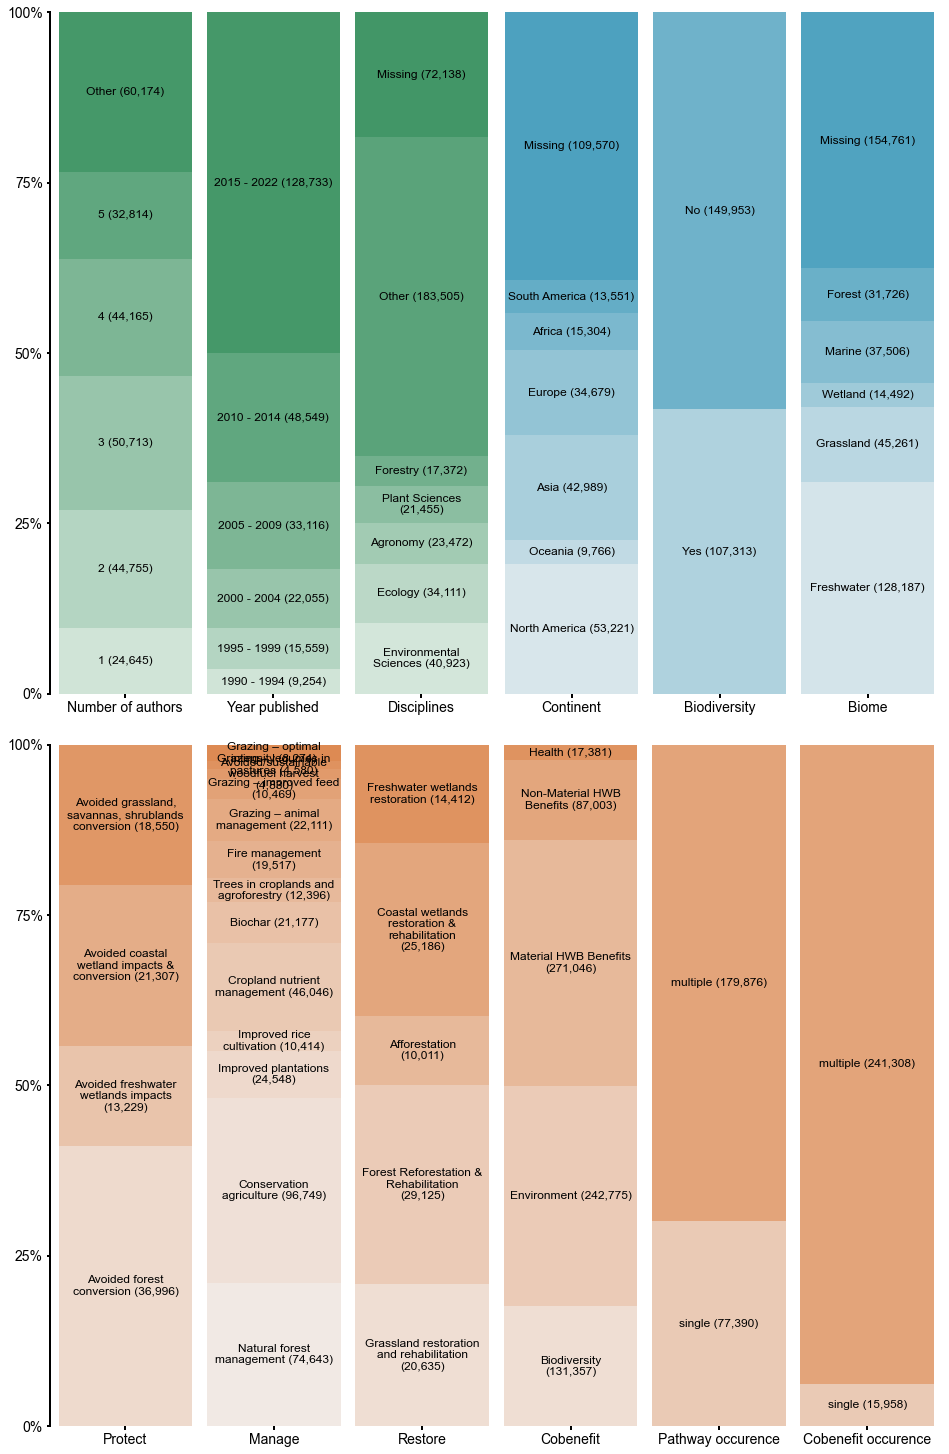

In [201]:
font_family_type = 'arial'
font_size = 14

plt.figure(figsize=(16,26))

plt.subplot(2, 2, 1) # divide as 2x2, plot top left
plot_stacked_bar_v2(
    data = publication_informaton_percentage.values*100, 
    series_labels = publication_informaton_percentage.index.tolist(), 
    category_labels = publication_informaton_percentage.columns.tolist(), 
    show_values=True, 
    value_format="{:.3f}",
    colors=sns.light_palette("seagreen", n_colors=42)[6::6] + sns.light_palette("seagreen", n_colors=42)[6::6] + sns.light_palette("seagreen", n_colors=48)[6::6],
    values_for_text= publication_informaton_value.values.tolist(), 
    barwidth=0.9
)
plt.legend('', frameon=False)
plt.yticks([100, 75, 50, 25, 0], ['100%', '75%', '50%', '25%', '0%'], fontsize=font_size, fontname = font_family_type)
plt.xticks(fontsize=font_size, fontname = font_family_type)
plt.margins(x=0.02)
plt.setp(plt.gca().spines.values(), linewidth=2)
plt.tick_params(width=2)

mpl.rcParams['axes.spines.left'] = False
plt.subplot(2, 2, 2) # divide as 2x2, plot top right
base_color = '#3A98B9'
plot_stacked_bar_v2(
    data = ecological_variables_percentage.values*100, 
    series_labels = ecological_variables_percentage.index.tolist(), 
    category_labels = ecological_variables_percentage.columns.tolist(), 
    show_values=True, 
    value_format="{:.3f}",
    colors=sns.light_palette(base_color, n_colors=48)[6::6] + 
            sns.light_palette(base_color, n_colors=18)[6::6] + 
            sns.light_palette(base_color, n_colors=42)[6::6],
    values_for_text= ecological_variables_value.values.tolist(),
    barwidth = 0.9
)
plt.legend('', frameon=False)
plt.yticks([], [])
plt.xticks(fontsize=font_size, fontname = font_family_type)
plt.margins(x=0.02)
plt.setp(plt.gca().spines.values(), linewidth=2)
plt.tick_params(width=2)

mpl.rcParams['axes.spines.left'] = True
plt.subplot(2, 1, 2) # divide as 2x1, plot bottom
base_color = '#DC8449'
plot_stacked_bar_v2(
    data = ncs_hwb_percentage.values*100, 
    series_labels = ncs_hwb_percentage.index.tolist(), 
    category_labels = ncs_hwb_percentage.columns.tolist(), 
    show_values=True, 
    value_format="{:.3f}",
    colors=sns.light_palette(base_color, n_colors=30)[6::6] + 
            sns.light_palette(base_color, n_colors=84)[6::6] + 
            sns.light_palette(base_color, n_colors=36)[6::6] + 
            sns.light_palette(base_color, n_colors=36)[6::6] + 
            sns.light_palette(base_color, n_colors=18)[6::6] + 
            sns.light_palette(base_color, n_colors=18)[6::6],
    values_for_text= ncs_hwb_value.values.tolist(),
    barwidth = 0.9
)

plt.legend('', frameon=False)
plt.yticks([100, 75, 50, 25, 0], ['100%', '75%', '50%', '25%', '0%'], fontsize=font_size, fontname = font_family_type)
plt.xticks(fontsize=font_size, fontname = font_family_type)
plt.margins(x=0.01)
plt.setp(plt.gca().spines.values(), linewidth=2)
plt.tick_params(width=2)

plt.subplots_adjust(wspace=0, hspace=0.075)

plt.savefig('combined_stacked_bar_charts_withmissing.png')
plt.savefig('combined_stacked_bar_charts_withmissing.pdf')

##### 1 by 1

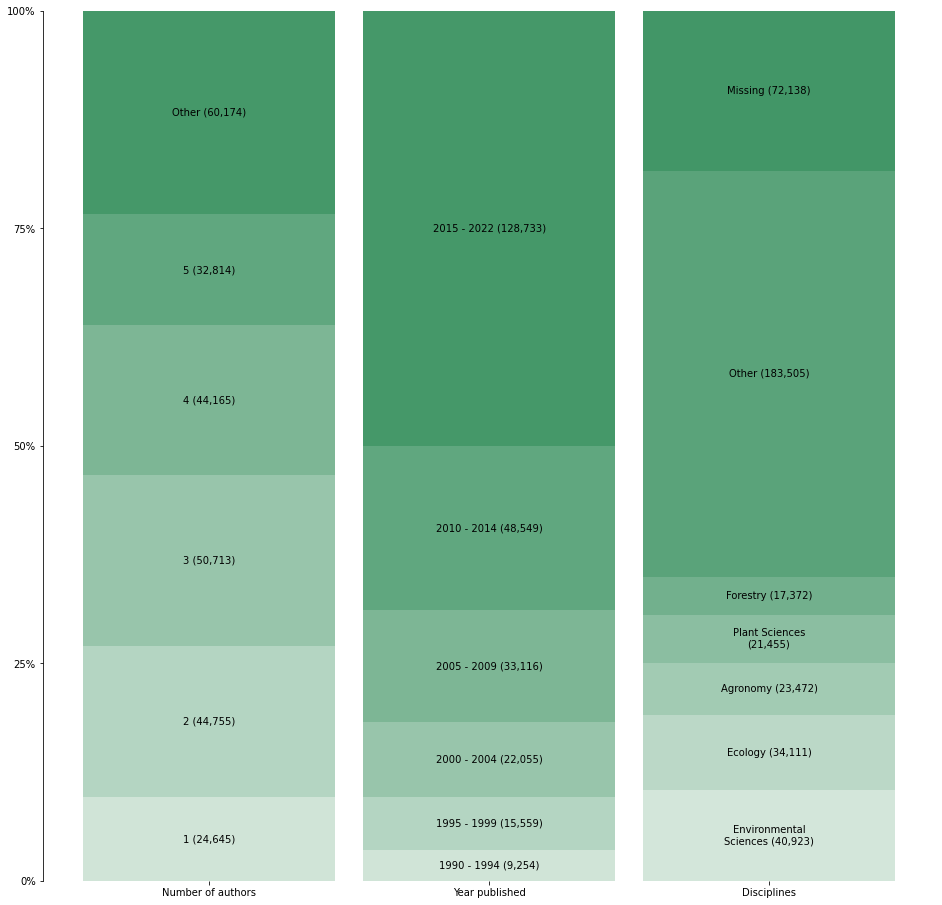

In [49]:
plt.figure(figsize=(16, 16))

plot_stacked_bar_v2(
    data = publication_informaton_percentage.values*100, 
    series_labels = publication_informaton_percentage.index.tolist(), 
    category_labels = publication_informaton_percentage.columns.tolist(), 
    show_values=True, 
    value_format="{:.3f}",
    colors=sns.light_palette("seagreen", n_colors=42)[6::6] + sns.light_palette("seagreen", n_colors=42)[6::6] + sns.light_palette("seagreen", n_colors=48)[6::6],
    #y_label="%",
    values_for_text= publication_informaton_value.values.tolist(), 
    barwidth=0.9
)

plt.legend('', frameon=False)
plt.yticks([100, 75, 50, 25, 0], ['100%', '75%', '50%', '25%', '0%'])
plt.savefig('publication_information_bar.png')
plt.savefig('publication_information_bar.pdf')
plt.show()

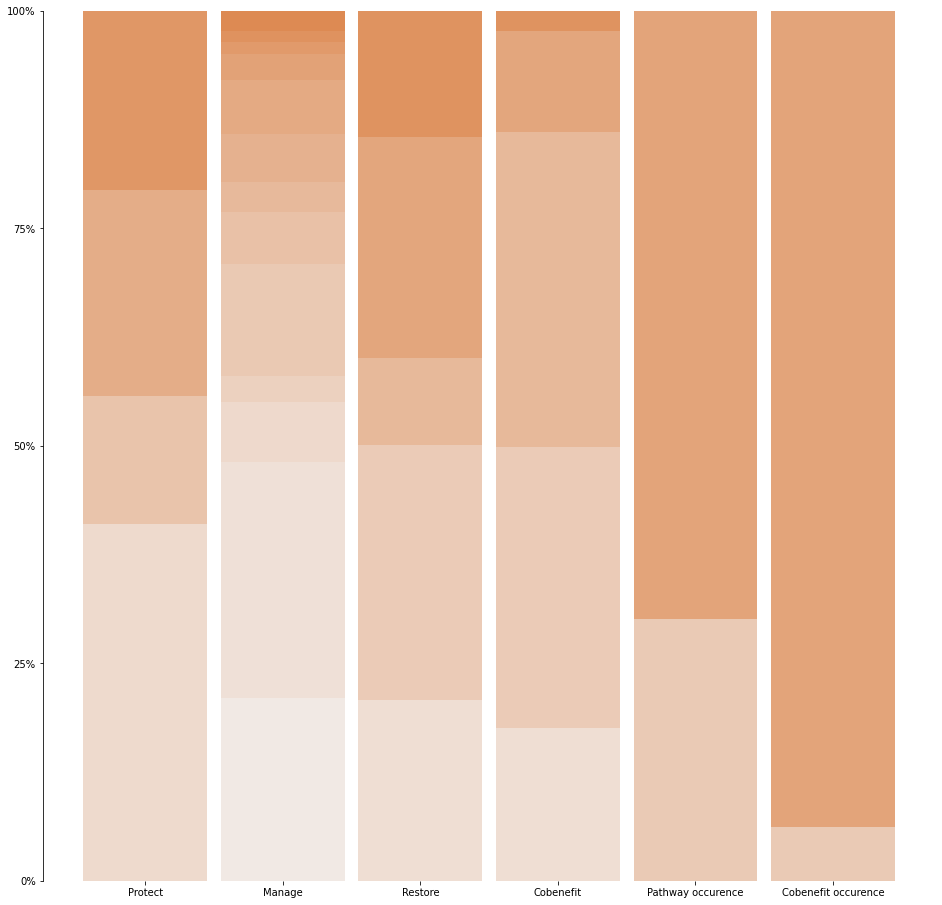

In [600]:
plt.figure(figsize=(16, 16))
base_color = '#DC8449'

plot_stacked_bar_v2(
    data = ncs_hwb_percentage.values*100, 
    series_labels = ncs_hwb_percentage.index.tolist(), 
    category_labels = ncs_hwb_percentage.columns.tolist(), 
    show_values=True, 
    value_format="{:.3f}",
    colors=sns.light_palette(base_color, n_colors=30)[6::6] + 
            sns.light_palette(base_color, n_colors=84)[6::6] + 
            sns.light_palette(base_color, n_colors=36)[6::6] + 
            sns.light_palette(base_color, n_colors=36)[6::6] + 
            sns.light_palette(base_color, n_colors=18)[6::6] + 
            sns.light_palette(base_color, n_colors=18)[6::6],
    #y_label="%",
    values_for_text= ncs_hwb_value.values.tolist(),
    barwidth = 0.9
)

plt.legend('', frameon=False)
plt.yticks([100, 75, 50, 25, 0], ['100%', '75%', '50%', '25%', '0%'])
plt.savefig('ncs_hwb_bar_without_missing.png')
plt.savefig('ncs_hwb_bar_without_missing.pdf')
plt.show()

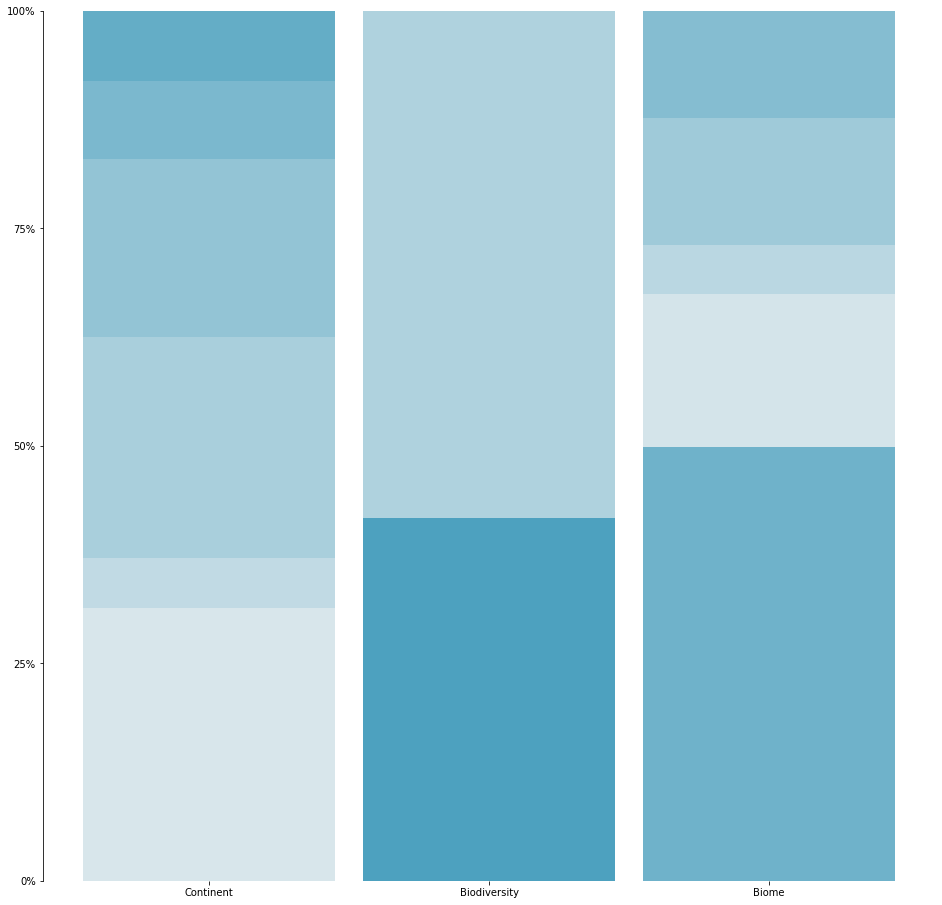

In [656]:
plt.figure(figsize=(16, 16))
base_color = '#3A98B9'

plot_stacked_bar_v2(
    data = ecological_variables_percentage.values*100, 
    series_labels = ecological_variables_percentage.index.tolist(), 
    category_labels = ecological_variables_percentage.columns.tolist(), 
    show_values=False, 
    value_format="{:.3f}",
    colors=sns.light_palette(base_color, n_colors=48)[6::6] + 
            sns.light_palette(base_color, n_colors=18)[6::6] + 
            sns.light_palette(base_color, n_colors=42)[6::6],
    #y_label="%",
    values_for_text= ecological_variables_value.values.tolist(),
    barwidth = 0.9
)

plt.legend('', frameon=False)
plt.yticks([100, 75, 50, 25, 0], ['100%', '75%', '50%', '25%', '0%'])
plt.savefig('ecological_variables_bar_without_missing&label.png')
plt.savefig('ecological_variables_bar_without_missing&label.pdf')
plt.show()

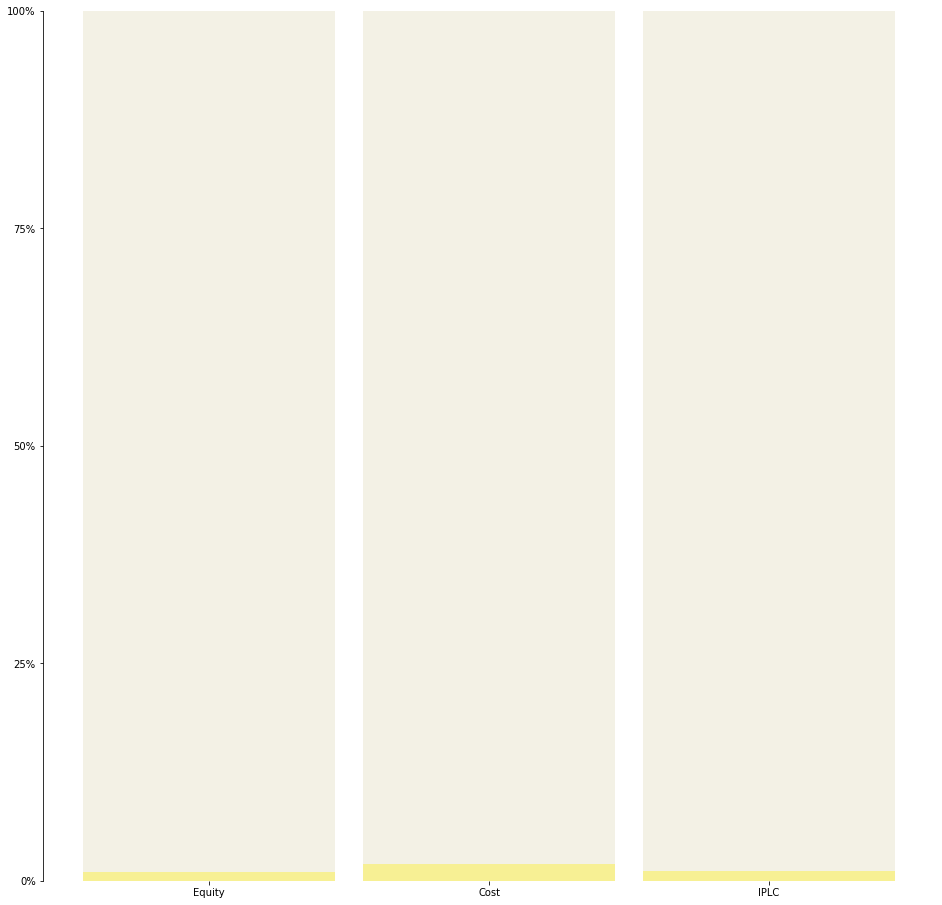

In [604]:
plt.figure(figsize=(16, 16))
base_color = '#FFED00'

plot_stacked_bar_v2(
    data = human_social_variables_percentage.values*100, 
    series_labels = human_social_variables_percentage.index.tolist(), 
    category_labels = human_social_variables_percentage.columns.tolist(), 
    show_values=True, 
    value_format="{:.3f}",
    colors=sns.light_palette(base_color, n_colors=18)[6::-6] + 
            sns.light_palette(base_color, n_colors=18)[6::-6] + 
            sns.light_palette(base_color, n_colors=18)[6::-6],
    #y_label="%",
    values_for_text= human_social_variables_value.values.tolist(),
    barwidth = 0.9
)

plt.legend('', frameon=False)
plt.yticks([100, 75, 50, 25, 0], ['100%', '75%', '50%', '25%', '0%'])
plt.savefig('human_social_variables_bar_without_missing.png')
plt.savefig('human_social_variables_bar_without_missing.pdf')
plt.show()